In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random
import matplotlib.image as mpimg
import pandas as pd
from PIL import Image
from tqdm import tqdm
import seaborn as sns
import keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras import models, optimizers, regularizers                                                        
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, BatchNormalization    
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping 

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import matplotlib.pyplot as plt
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


In [2]:


train_labels_csv = '/kaggle/input/datadriven-conservision/train_labels.csv'
train_features_csv = '/kaggle/input/datadriven-conservision/train_features.csv'
test_features_csv = '/kaggle/input/datadriven-conservision/test_features.csv'
submission_csv = '/kaggle/working/submission_format_empty.csv'

train_features = pd.read_csv(train_features_csv, index_col = 'id')
test_features = pd.read_csv(test_features_csv, index_col="id")
train_labels = pd.read_csv(train_labels_csv, index_col="id")

animal_labels = list(train_labels.columns.unique())



train_features_images = '/kaggle/input/datadriven-conservision/train_features/'
test_features_images = '/kaggle/input/datadriven-conservision/test_features/'
val_features_images = '/kaggle/input/datadriven-conservision/val_features/'


In [3]:
base_filters = 32
lrate = 0.001
l1 = 0.
l2 = 0.
w_regularizers = 1e-5
regularizer = tf.keras.regularizers.l1_l2(l1, l2)
IMG_HEIGHT = 512
IMG_WIDTH =  512
image_size = (IMG_HEIGHT, IMG_WIDTH)
batch_size = 256
NUM_CHANNELS = 3

In [5]:

train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    train_features_images,
    labels = 'inferred',
    label_mode = 'categorical',
    validation_split=0.2,
    subset="both",
    seed=13,
    image_size=image_size,
    batch_size=batch_size,
)

Found 13101 files belonging to 8 classes.
Using 10481 files for training.
Using 2620 files for validation.


In [6]:
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 8), dtype=tf.float32, name=None))>

In [7]:
val_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 8), dtype=tf.float32, name=None))>

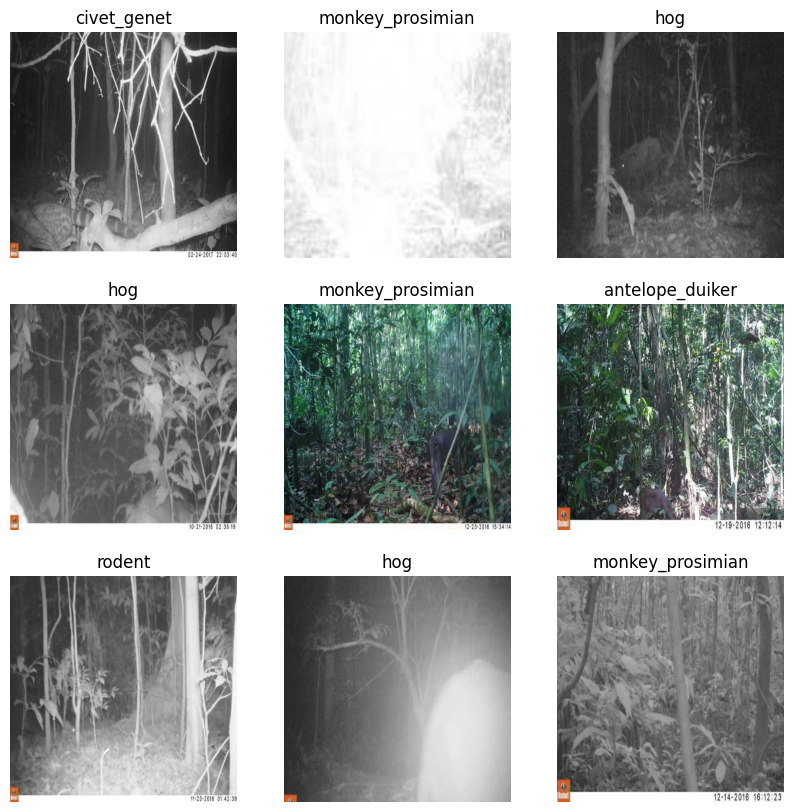

In [8]:
 import matplotlib.pyplot as plt

 plt.figure(figsize=(10, 10))
 for images, labels in train_ds.take(1):
     for i in range(9):
         ax = plt.subplot(3, 3, i + 1)
         plt.imshow(images[i].numpy().astype("uint8"))
         plt.title(animal_labels[np.argmax(labels[i])])
         plt.axis("off")


In [9]:
import tensorflow as tf

data_aug = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(
        mode='horizontal',
        name='random_lr_flip_none'  # Updated name without `/`
    )
])


In [10]:
# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_aug(img), label),
    num_parallel_calls=tf.data.AUTOTUNE
    
)

In [11]:
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)


In [12]:
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 8), dtype=tf.float32, name=None))>

In [13]:
val_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 8), dtype=tf.float32, name=None))>

In [14]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.optimizers import Adam

# Define the variables
IMG_HEIGHT = 512
IMG_WIDTH = 512
num_classes = 8  # Number of output classes

# Load the pre-trained ResNet-101 model (excluding the top layer)
base_model = ResNet101(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    if not isinstance(layer, layers.BatchNormalization):  # Leave BatchNorm layers trainable
        layer.trainable = False

# Build the model using the Functional API for better flexibility
inputs = layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = base_model(inputs, training=False)  # Ensure base_model stays in inference mode
x = layers.GlobalAveragePooling2D()(x)  # Global Average Pooling layer

# Fully connected layers
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)

# Output layer for classification
outputs = layers.Dense(num_classes, activation='softmax')(x)

# Create the final model
model = models.Model(inputs, outputs)

# Compile the model with fine-tuning adjustments
model.compile(
    optimizer=Adam(learning_rate=1e-4),  # Smaller initial learning rate for better convergence
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Print the model summary
model.summary()
# Save the final retrained model
model.save('/kaggle/working/resnet101_model.keras')
print("Final retrained model saved successfully!")

171446536/171446536 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 512, 512, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet101 (Functional)               │ (None, 16, 16, 2048)        │      42,658,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 8)                   │           1,032 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 43,872,520 (167.36 MB)

 Trainable params: 1,319,688 (5.03 MB)

 Non-trainable params: 42,552,832 (162.33 MB)

Final retrained model saved successfully!


In [15]:
next(iter(val_ds))

(<tf.Tensor: shape=(256, 512, 512, 3), dtype=float32, numpy=
 array([[[[156.875   , 156.875   , 156.875   ],
          [154.875   , 154.875   , 154.875   ],
          [151.75    , 151.75    , 151.75    ],
          ...,
          [114.375   , 114.375   , 114.375   ],
          [115.625   , 115.625   , 115.625   ],
          [116.      , 116.      , 116.      ]],
 
         [[156.25098 , 156.25098 , 156.25098 ],
          [153.97363 , 153.97363 , 153.97363 ],
          [150.84863 , 150.84863 , 150.84863 ],
          ...,
          [114.16699 , 114.16699 , 114.16699 ],
          [115.07031 , 115.07031 , 115.07031 ],
          [115.44531 , 115.44531 , 115.44531 ]],
 
         [[155.00879 , 155.00879 , 155.00879 ],
          [152.6377  , 152.6377  , 152.6377  ],
          [149.5127  , 149.5127  , 149.5127  ],
          ...,
          [114.      , 114.      , 114.      ],
          [114.302734, 114.302734, 114.302734],
          [114.484375, 114.484375, 114.484375]],
 
         ...,
 
     

In [16]:
next(iter(train_ds))

(<tf.Tensor: shape=(256, 512, 512, 3), dtype=float32, numpy=
 array([[[[155.25    , 155.25    , 155.25    ],
          [157.375   , 157.375   , 157.375   ],
          [158.625   , 158.625   , 158.625   ],
          ...,
          [155.125   , 155.125   , 155.125   ],
          [148.875   , 148.875   , 148.875   ],
          [144.375   , 144.375   , 144.375   ]],
 
         [[155.18066 , 155.18066 , 155.18066 ],
          [157.02832 , 157.02832 , 157.02832 ],
          [158.625   , 158.625   , 158.625   ],
          ...,
          [154.91699 , 154.91699 , 154.91699 ],
          [147.97363 , 147.97363 , 147.97363 ],
          [143.26562 , 143.26562 , 143.26562 ]],
 
         [[155.125   , 155.125   , 155.125   ],
          [156.65332 , 156.65332 , 156.65332 ],
          [158.36719 , 158.36719 , 158.36719 ],
          ...,
          [154.49219 , 154.49219 , 154.49219 ],
          [146.83105 , 146.83105 , 146.83105 ],
          [141.85938 , 141.85938 , 141.85938 ]],
 
         ...,
 
     

In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
import datetime

# Hyperparameters
IMG_HEIGHT = 512  # Reduced resolution
IMG_WIDTH = 512
image_size = (IMG_HEIGHT, IMG_WIDTH)
batch_size = 8  # Reduced batch size
lrate = 0.001
epochs = 5

# Paths to datasets
train_data_dir = '/kaggle/input/datadriven-conservision/train_features'
validation_data_dir = '/kaggle/input/datadriven-conservision/val_features'

# Load the pre-trained model
model_path = '/kaggle/working/resnet101_model.keras'
try:
    model = load_model(model_path)
    print("Model loaded successfully!")
except Exception as e:
    print(f"Error loading model: {e}")
    raise

# Data augmentation configuration
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1.0 / 255)

# Create data generators
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=True
)

validation_generator = val_datagen.flow_from_directory(
    validation_data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=False
)

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lrate),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Add EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Add TensorBoard callback for visualization
log_dir = os.path.join("/kaggle/working/logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Train the model
print("Starting training...")
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=[early_stopping, tensorboard_callback],
    verbose=1
)

# Save the retrained model
retrained_model_path = '/kaggle/working/myresnet101.1_model.h5'
model.save(retrained_model_path)
print(f"Retrained model saved to: {retrained_model_path}")


Model Summary:


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 434 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 512, 512, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet101 (Functional)               │ (None, 16, 16, 2048)        │      42,658,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 8)                   │           1,032 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 46,511,898 (177.43 MB)

 Trainable params: 1,319,688 (5.03 MB)

 Non-trainable params: 42,552,832 (162.33 MB)

 Optimizer params: 2,639,378 (10.07 MB)

Found 3388 images belonging to 8 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


106/106 ━━━━━━━━━━━━━━━━━━━━ 121s 966ms/step


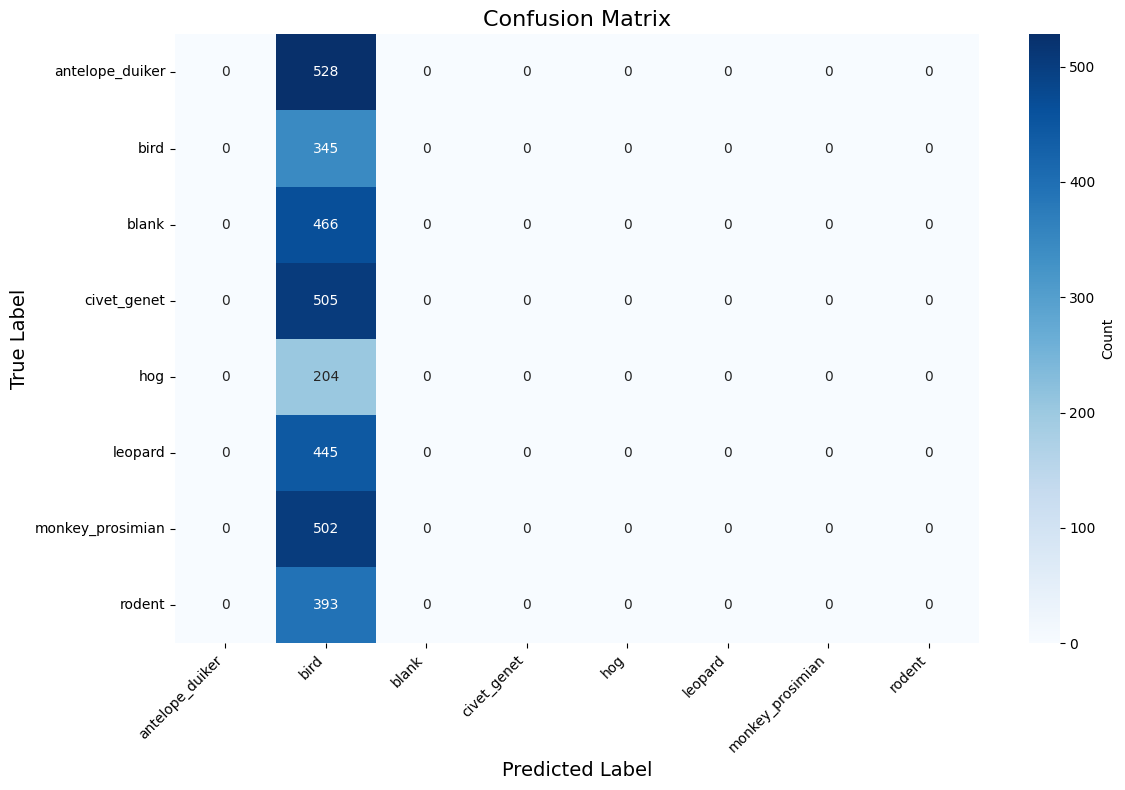

Classification Report:
                  precision   recall  f1-score     support
antelope_duiker    0.000000  0.00000  0.000000   528.00000
bird               0.101830  1.00000  0.184838   345.00000
blank              0.000000  0.00000  0.000000   466.00000
civet_genet        0.000000  0.00000  0.000000   505.00000
hog                0.000000  0.00000  0.000000   204.00000
leopard            0.000000  0.00000  0.000000   445.00000
monkey_prosimian   0.000000  0.00000  0.000000   502.00000
rodent             0.000000  0.00000  0.000000   393.00000
accuracy           0.101830  0.10183  0.101830     0.10183
macro avg          0.012729  0.12500  0.023105  3388.00000
weighted avg       0.010369  0.10183  0.018822  3388.00000

Class-Wise Metrics Table:
                             Class  Precision  Recall  F1-Score  Support
antelope_duiker    antelope_duiker    0.00000     0.0  0.000000    528.0
bird                          bird    0.10183     1.0  0.184838    345.0
blank                  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [17]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

# Paths
model_path = "/kaggle/working/resnet101_model.keras"
val_dataset_path = "/kaggle/input/datadriven-conservision/val_features"

# Load the pre-trained model
model = load_model(model_path)

# Check model summary and expected input shape
print("Model Summary:")
model.summary()
expected_input_shape = model.input_shape[1:3]  # Extract expected height and width

# Data generator for the validation dataset
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0 / 255)

# Ensure validation generator uses the correct input shape
val_generator = datagen.flow_from_directory(
    val_dataset_path,
    target_size=expected_input_shape,  # Match model's expected input shape
    batch_size=32,  # Use a batch size of 32
    class_mode="categorical",  # Model expects categorical (one-hot encoded) labels
    shuffle=False  # Maintain order for consistency in predictions and ground truth
)

# Predict on the validation dataset
try:
    # Ground truth labels and predictions
    y_true = val_generator.classes  # True labels from the validation generator
    y_pred_prob = model.predict(val_generator, verbose=1)  # Predicted probabilities
    y_pred = np.argmax(y_pred_prob, axis=1)  # Convert probabilities to class predictions
except ValueError as e:
    print("Error during prediction:", e)
    raise

# Get class names from the validation generator
class_names = list(val_generator.class_indices.keys())

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(12, 8))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names,
    cbar_kws={"label": "Count"},
)
plt.title("Confusion Matrix", fontsize=16)
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("True Label", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Classification report
report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)

# Convert the classification report to a DataFrame for better readability
report_df = pd.DataFrame(report).transpose()

# Print the classification report
print("Classification Report:")
print(report_df)

# Save the classification metrics to a CSV file
report_df.to_csv("classification_metrics_val.csv", index=True)

# Extract class-wise metrics
accuracy = accuracy_score(y_true, y_pred)
class_wise_metrics = report_df.loc[class_names, ["precision", "recall", "f1-score"]]
class_wise_metrics["support"] = report_df.loc[class_names, "support"]

# Create class-wise metrics table
accuracy_table = pd.DataFrame({
    "Class": class_names,
    "Precision": class_wise_metrics["precision"],
    "Recall": class_wise_metrics["recall"],
    "F1-Score": class_wise_metrics["f1-score"],
    "Support": class_wise_metrics["support"]
})
print("\nClass-Wise Metrics Table:")
print(accuracy_table)

# Save the accuracy table as a CSV file
accuracy_table.to_csv("class_wise_metrics_val.csv", index=False)

# Print overall accuracy
print(f"\nOverall Accuracy: {accuracy * 100:.2f}%")


Model Summary:


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 512, 512, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet101 (Functional)               │ (None, 16, 16, 2048)        │      42,658,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 8)                   │           1,032 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 43,872,522 (167.36 MB)

 Trainable params: 1,319,688 (5.03 MB)

 Non-trainable params: 42,552,832 (162.33 MB)

 Optimizer params: 2 (12.00 B)

Found 3388 images belonging to 8 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


106/106 ━━━━━━━━━━━━━━━━━━━━ 99s 894ms/step


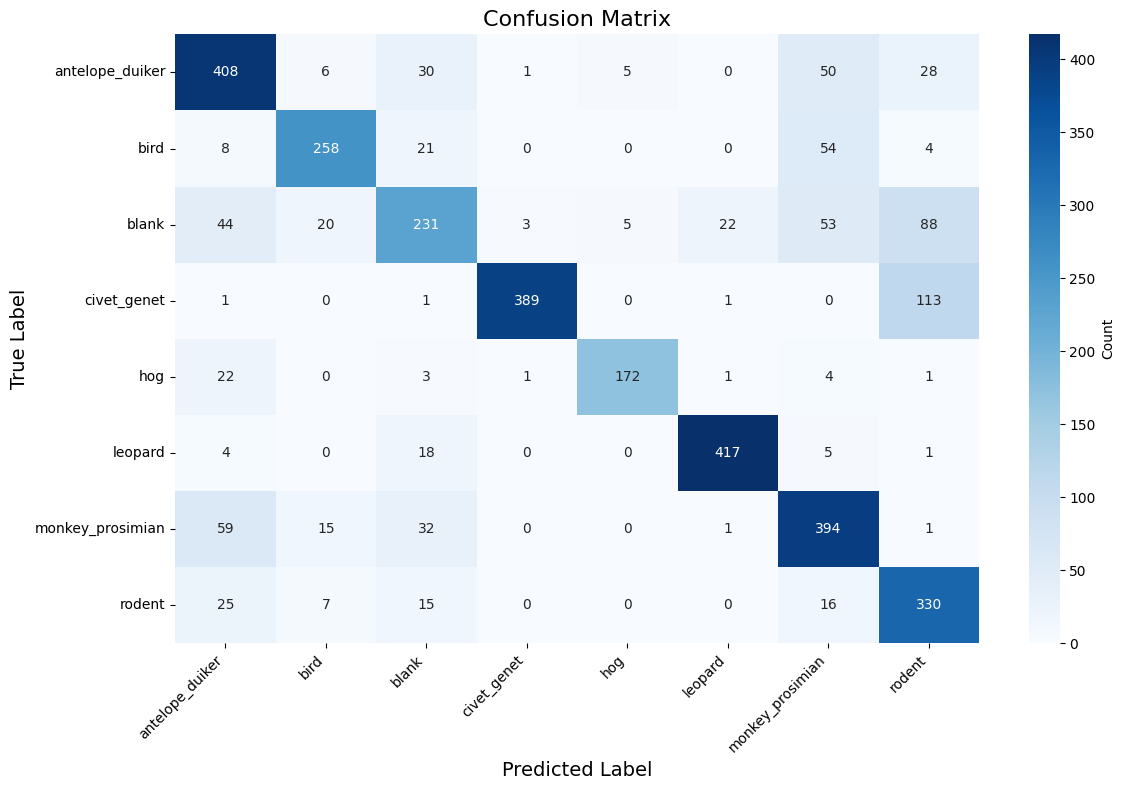

Classification Report:
                  precision    recall  f1-score      support
antelope_duiker    0.714536  0.772727  0.742493   528.000000
bird               0.843137  0.747826  0.792627   345.000000
blank              0.658120  0.495708  0.565483   466.000000
civet_genet        0.987310  0.770297  0.865406   505.000000
hog                0.945055  0.843137  0.891192   204.000000
leopard            0.943439  0.937079  0.940248   445.000000
monkey_prosimian   0.684028  0.784861  0.730983   502.000000
rodent             0.583039  0.839695  0.688217   393.000000
accuracy           0.767119  0.767119  0.767119     0.767119
macro avg          0.794833  0.773916  0.777081  3388.000000
weighted avg       0.784702  0.767119  0.768499  3388.000000

Class-Wise Metrics Table:
                             Class  Precision    Recall  F1-Score  Support
antelope_duiker    antelope_duiker   0.714536  0.772727  0.742493    528.0
bird                          bird   0.843137  0.747826  0.792627   

In [21]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

# Paths
model_path = "/kaggle/input/resnet3.4/other/default/1/myresnet101.3_model.h5"
val_dataset_path = "/kaggle/input/datadriven-conservision/val_features"

# Load the pre-trained model
model = load_model(model_path)

# Check model summary and expected input shape
print("Model Summary:")
model.summary()
expected_input_shape = model.input_shape[1:3]  # Extract expected height and width

# Data generator for the validation dataset
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0 / 255)

# Ensure validation generator uses the correct input shape
val_generator = datagen.flow_from_directory(
    val_dataset_path,
    target_size=expected_input_shape,  # Match model's expected input shape
    batch_size=32,  # Use a batch size of 32
    class_mode="categorical",  # Model expects categorical (one-hot encoded) labels
    shuffle=False  # Maintain order for consistency in predictions and ground truth
)

# Predict on the validation dataset
try:
    # Ground truth labels and predictions
    y_true = val_generator.classes  # True labels from the validation generator
    y_pred_prob = model.predict(val_generator, verbose=1)  # Predicted probabilities
    y_pred = np.argmax(y_pred_prob, axis=1)  # Convert probabilities to class predictions
except ValueError as e:
    print("Error during prediction:", e)
    raise

# Get class names from the validation generator
class_names = list(val_generator.class_indices.keys())

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(12, 8))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names,
    cbar_kws={"label": "Count"},
)
plt.title("Confusion Matrix", fontsize=16)
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("True Label", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Classification report
report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)

# Convert the classification report to a DataFrame for better readability
report_df = pd.DataFrame(report).transpose()

# Print the classification report
print("Classification Report:")
print(report_df)

# Save the classification metrics to a CSV file
report_df.to_csv("classification_metrics_val.csv", index=True)

# Extract class-wise metrics
accuracy = accuracy_score(y_true, y_pred)
class_wise_metrics = report_df.loc[class_names, ["precision", "recall", "f1-score"]]
class_wise_metrics["support"] = report_df.loc[class_names, "support"]

# Create class-wise metrics table
accuracy_table = pd.DataFrame({
    "Class": class_names,
    "Precision": class_wise_metrics["precision"],
    "Recall": class_wise_metrics["recall"],
    "F1-Score": class_wise_metrics["f1-score"],
    "Support": class_wise_metrics["support"]
})
print("\nClass-Wise Metrics Table:")
print(accuracy_table)

# Save the accuracy table as a CSV file
accuracy_table.to_csv("class_wise_metrics_val.csv", index=False)

# Print overall accuracy
print(f"\nOverall Accuracy: {accuracy * 100:.2f}%")


Model Summary:


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 512, 512, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet101 (Functional)               │ (None, 16, 16, 2048)        │      42,658,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 8)                   │           1,032 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 43,872,522 (167.36 MB)

 Trainable params: 1,319,688 (5.03 MB)

 Non-trainable params: 42,552,832 (162.33 MB)

 Optimizer params: 2 (12.00 B)

Found 3388 images belonging to 8 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


106/106 ━━━━━━━━━━━━━━━━━━━━ 99s 900ms/step


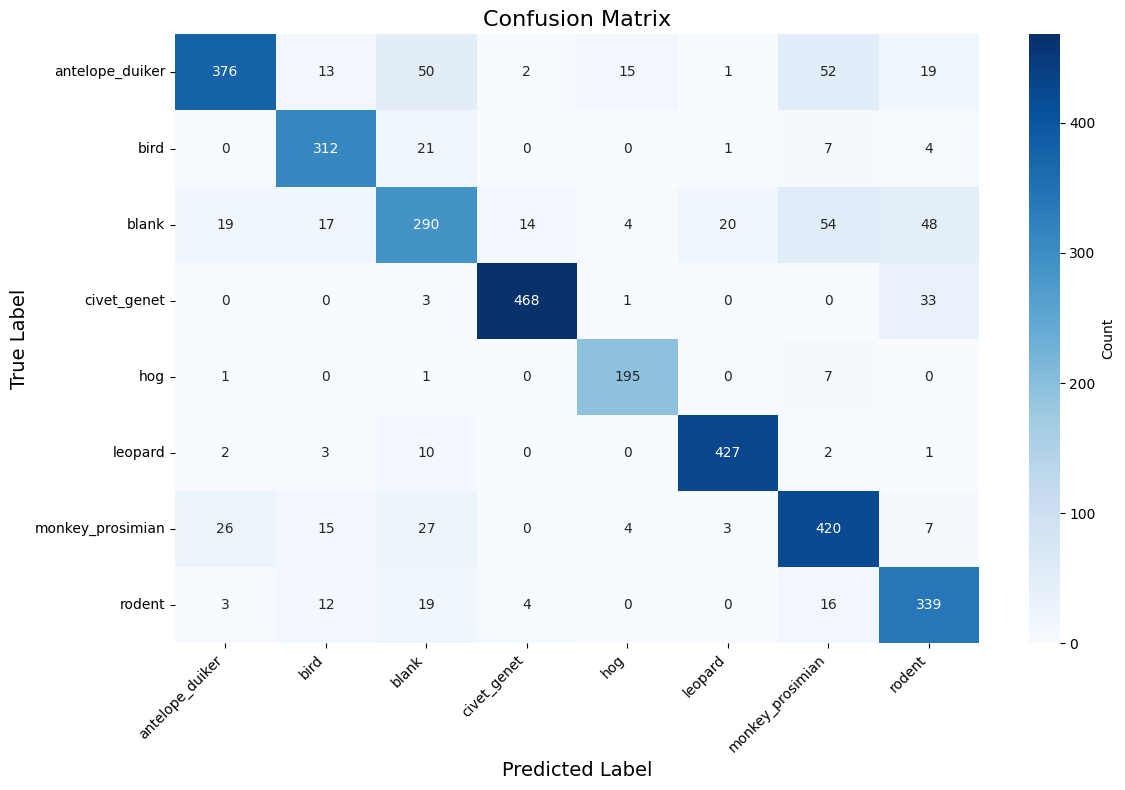

Classification Report:
                  precision    recall  f1-score      support
antelope_duiker    0.880562  0.712121  0.787435   528.000000
bird               0.838710  0.904348  0.870293   345.000000
blank              0.688836  0.622318  0.653890   466.000000
civet_genet        0.959016  0.926733  0.942598   505.000000
hog                0.890411  0.955882  0.921986   204.000000
leopard            0.944690  0.959551  0.952062   445.000000
monkey_prosimian   0.752688  0.836653  0.792453   502.000000
rodent             0.751663  0.862595  0.803318   393.000000
accuracy           0.834416  0.834416  0.834416     0.834416
macro avg          0.838322  0.847525  0.840504  3388.000000
weighted avg       0.836740  0.834416  0.832942  3388.000000

Class-Wise Metrics Table:
                             Class  Precision    Recall  F1-Score  Support
antelope_duiker    antelope_duiker   0.880562  0.712121  0.787435    528.0
bird                          bird   0.838710  0.904348  0.870293   

In [22]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

# Paths
model_path = "/kaggle/input/final/other/default/1/myresnet1013.6_model.h5"
val_dataset_path = "/kaggle/input/datadriven-conservision/val_features"

# Load the pre-trained model
model = load_model(model_path)

# Check model summary and expected input shape
print("Model Summary:")
model.summary()
expected_input_shape = model.input_shape[1:3]  # Extract expected height and width

# Data generator for the validation dataset
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0 / 255)

# Ensure validation generator uses the correct input shape
val_generator = datagen.flow_from_directory(
    val_dataset_path,
    target_size=expected_input_shape,  # Match model's expected input shape
    batch_size=32,  # Use a batch size of 32
    class_mode="categorical",  # Model expects categorical (one-hot encoded) labels
    shuffle=False  # Maintain order for consistency in predictions and ground truth
)

# Predict on the validation dataset
try:
    # Ground truth labels and predictions
    y_true = val_generator.classes  # True labels from the validation generator
    y_pred_prob = model.predict(val_generator, verbose=1)  # Predicted probabilities
    y_pred = np.argmax(y_pred_prob, axis=1)  # Convert probabilities to class predictions
except ValueError as e:
    print("Error during prediction:", e)
    raise

# Get class names from the validation generator
class_names = list(val_generator.class_indices.keys())

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(12, 8))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names,
    cbar_kws={"label": "Count"},
)
plt.title("Confusion Matrix", fontsize=16)
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("True Label", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Classification report
report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)

# Convert the classification report to a DataFrame for better readability
report_df = pd.DataFrame(report).transpose()

# Print the classification report
print("Classification Report:")
print(report_df)

# Save the classification metrics to a CSV file
report_df.to_csv("classification_metrics_val.csv", index=True)

# Extract class-wise metrics
accuracy = accuracy_score(y_true, y_pred)
class_wise_metrics = report_df.loc[class_names, ["precision", "recall", "f1-score"]]
class_wise_metrics["support"] = report_df.loc[class_names, "support"]

# Create class-wise metrics table
accuracy_table = pd.DataFrame({
    "Class": class_names,
    "Precision": class_wise_metrics["precision"],
    "Recall": class_wise_metrics["recall"],
    "F1-Score": class_wise_metrics["f1-score"],
    "Support": class_wise_metrics["support"]
})
print("\nClass-Wise Metrics Table:")
print(accuracy_table)

# Save the accuracy table as a CSV file
accuracy_table.to_csv("class_wise_metrics_val.csv", index=False)

# Print overall accuracy
print(f"\nOverall Accuracy: {accuracy * 100:.2f}%")


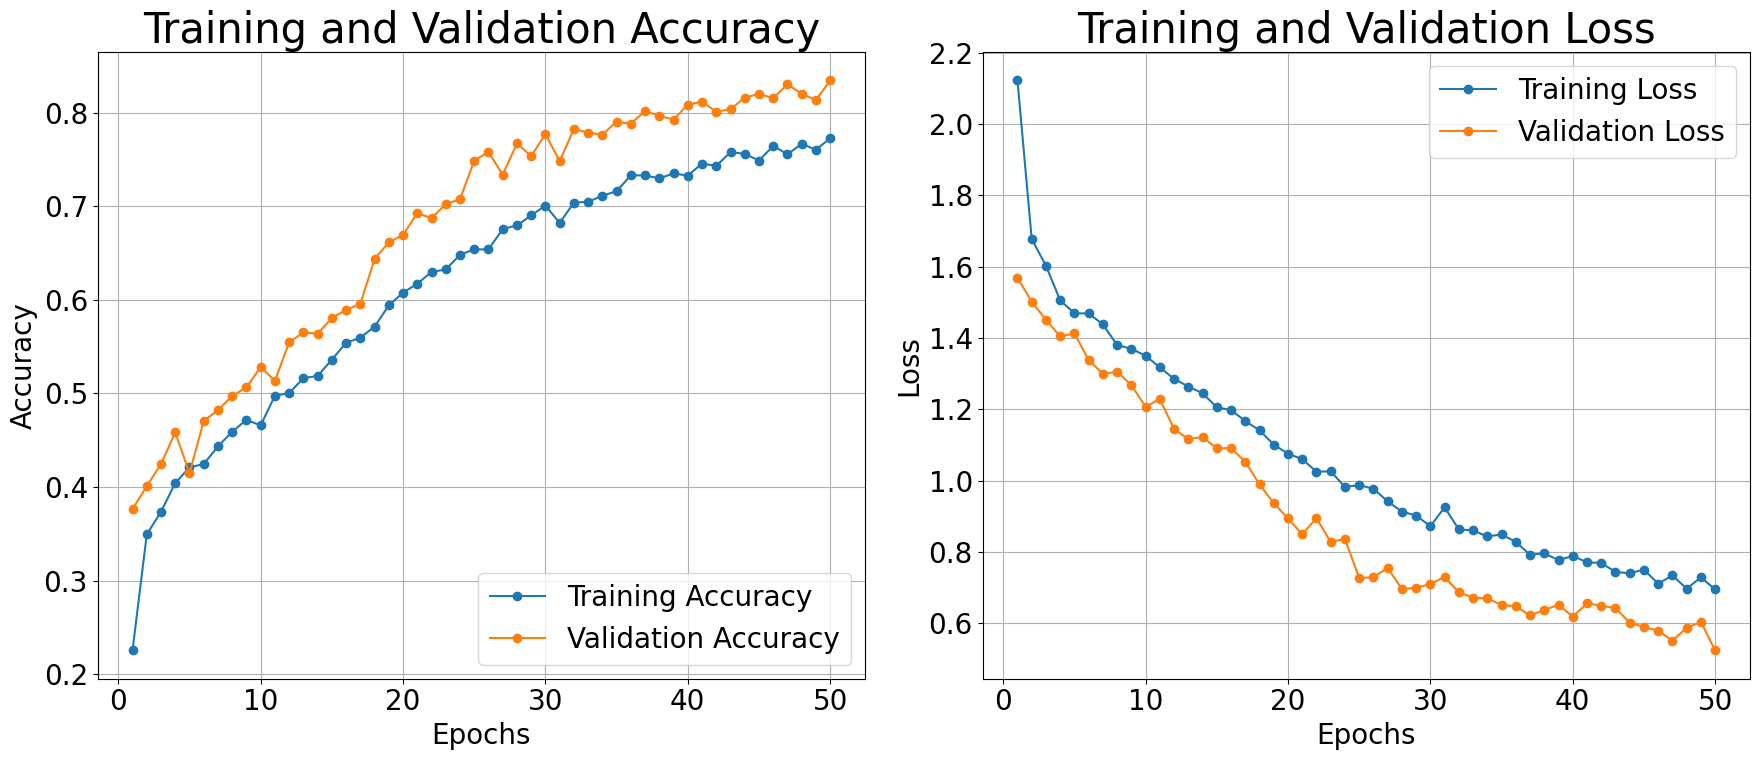

In [23]:
import matplotlib.pyplot as plt

# Update matplotlib's default font sizes
plt.rcParams.update({
    'font.size': 20,  # General font size
    'axes.titlesize': 30,  # Title font size
    'axes.labelsize': 20,  # Axis label font size
    'legend.fontsize': 20,  # Legend font size
    'xtick.labelsize': 20,  # X-axis tick font size
    'ytick.labelsize': 20   # Y-axis tick font size
})

# Combine all accuracy and loss data from both training sessions
all_acc = [
    0.2257, 0.3494, 0.3737, 0.4042, 0.4211, 0.4246, 0.4435, 0.4592, 0.4718, 0.4660,
    0.4976, 0.5004, 0.5164, 0.5187, 0.5361, 0.5542, 0.5596, 0.5714, 0.5941, 0.6078,
    0.6172, 0.6298, 0.6325, 0.6482, 0.6540, 0.6539, 0.6757, 0.6795, 0.6902, 0.7008,
    0.6822, 0.7039, 0.7048, 0.7112, 0.7162, 0.7330, 0.7330, 0.7298, 0.7351, 0.7328,
    0.7457, 0.7431, 0.7579, 0.7560, 0.7489, 0.7645, 0.7555, 0.7668, 0.7603, 0.7728
]
all_val_acc = [
    0.3766, 0.4008, 0.4247, 0.4584, 0.4150, 0.4705, 0.4823, 0.4973, 0.5065, 0.5283,
    0.5136, 0.5546, 0.5652, 0.5638, 0.5806, 0.5894, 0.5956, 0.6437, 0.6615, 0.6694,
    0.6927, 0.6874, 0.7022, 0.7075, 0.7488, 0.7580, 0.7338, 0.7671, 0.7535, 0.7772,
    0.7482, 0.7825, 0.7786, 0.7766, 0.7904, 0.7881, 0.8019, 0.7966, 0.7925, 0.8087,
    0.8117, 0.8011, 0.8037, 0.8161, 0.8200, 0.8155, 0.8303, 0.8202, 0.8135, 0.8344
]
all_loss = [
    2.1226, 1.6778, 1.6028, 1.5057, 1.4693, 1.4689, 1.4383, 1.3801, 1.3699, 1.3503,
    1.3176, 1.2853, 1.2639, 1.2450, 1.2056, 1.1981, 1.1668, 1.1411, 1.1010, 1.0753,
    1.0603, 1.0248, 1.0261, 0.9821, 0.9874, 0.9773, 0.9416, 0.9131, 0.9020, 0.8720,
    0.9248, 0.8631, 0.8600, 0.8432, 0.8490, 0.8280, 0.7918, 0.7957, 0.7771, 0.7886,
    0.7709, 0.7687, 0.7438, 0.7399, 0.7503, 0.7106, 0.7340, 0.6967, 0.7283, 0.6949
]
all_val_loss = [
    1.5688, 1.5019, 1.4513, 1.4043, 1.4130, 1.3381, 1.2995, 1.3054, 1.2681, 1.2067,
    1.2289, 1.1447, 1.1164, 1.1225, 1.0901, 1.0915, 1.0525, 0.9894, 0.9369, 0.8938,
    0.8492, 0.8946, 0.8277, 0.8361, 0.7267, 0.7288, 0.7551, 0.6955, 0.6992, 0.7099,
    0.7293, 0.6865, 0.6719, 0.6693, 0.6511, 0.6474, 0.6216, 0.6370, 0.6514, 0.6184,
    0.6555, 0.6491, 0.6420, 0.6015, 0.5892, 0.5786, 0.5509, 0.5866, 0.6034, 0.5240
]

# Plot accuracy
epochs = range(1, len(all_acc) + 1)
plt.figure(figsize=(18, 8))

plt.subplot(1, 2, 1)
plt.plot(epochs, all_acc, label='Training Accuracy', marker='o')
plt.plot(epochs, all_val_acc, label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(epochs, all_loss, label='Training Loss', marker='o')
plt.plot(epochs, all_val_loss, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Display plots
plt.tight_layout()
plt.show()


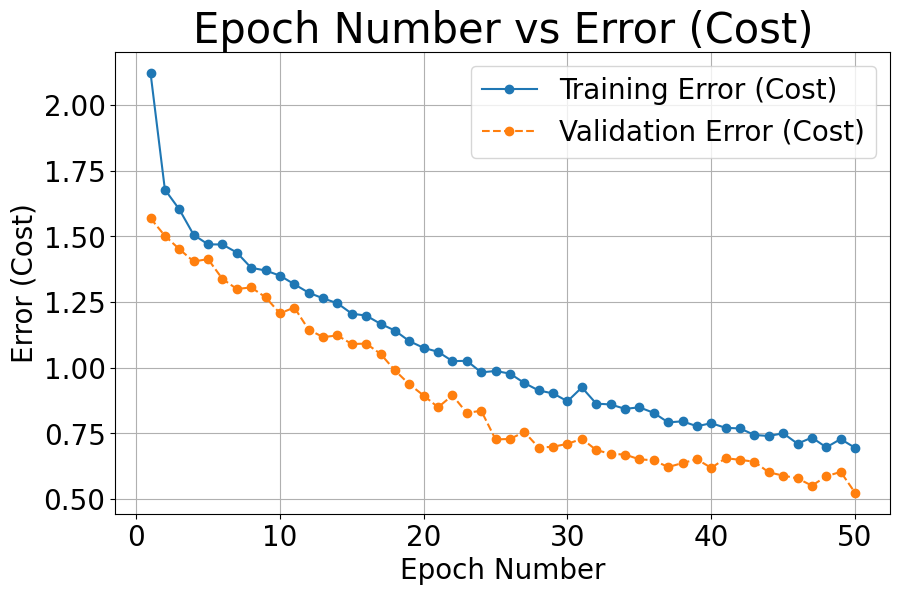

In [24]:
import matplotlib.pyplot as plt

# Define the epochs
epochs = range(1, len(all_loss) + 1)

# Plot the cost (error)
plt.figure(figsize=(10, 6))
plt.plot(epochs, all_loss, label='Training Error (Cost)', marker='o', linestyle='-')
plt.plot(epochs, all_val_loss, label='Validation Error (Cost)', marker='o', linestyle='--')
plt.title('Epoch Number vs Error (Cost)')
plt.xlabel('Epoch Number')
plt.ylabel('Error (Cost)')
plt.legend()
plt.grid(True)

# Display the plot
plt.show()


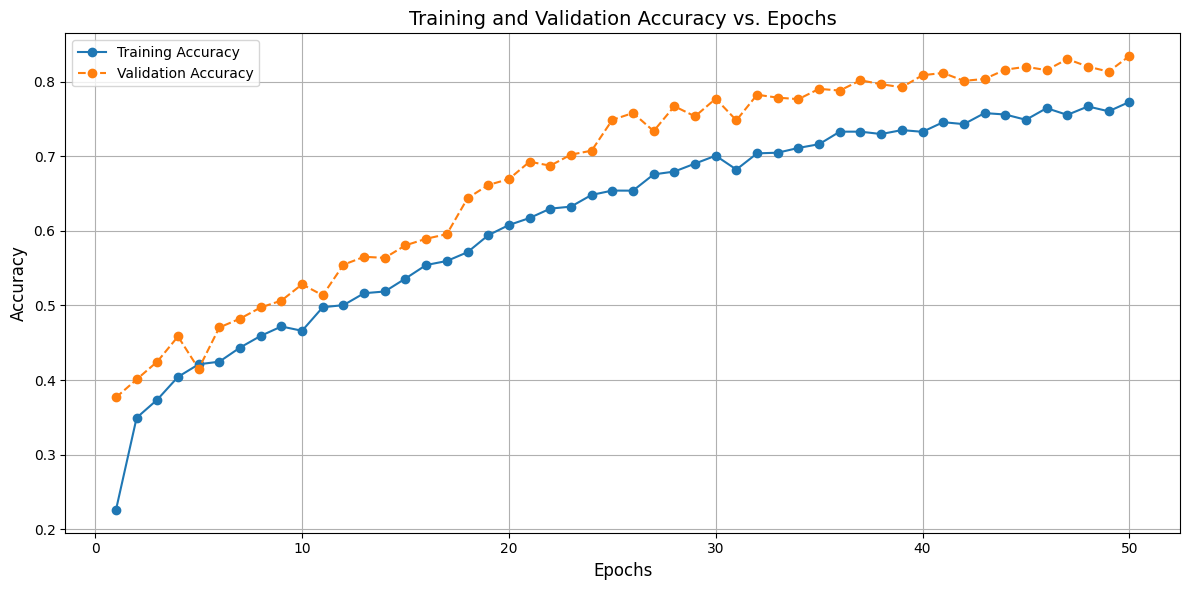

In [4]:
import matplotlib.pyplot as plt
# Combine all accuracy and loss data from both training sessions
all_acc = [
    0.2257, 0.3494, 0.3737, 0.4042, 0.4211, 0.4246, 0.4435, 0.4592, 0.4718, 0.4660,
    0.4976, 0.5004, 0.5164, 0.5187, 0.5361, 0.5542, 0.5596, 0.5714, 0.5941, 0.6078,
    0.6172, 0.6298, 0.6325, 0.6482, 0.6540, 0.6539, 0.6757, 0.6795, 0.6902, 0.7008,
    0.6822, 0.7039, 0.7048, 0.7112, 0.7162, 0.7330, 0.7330, 0.7298, 0.7351, 0.7328,
    0.7457, 0.7431, 0.7579, 0.7560, 0.7489, 0.7645, 0.7555, 0.7668, 0.7603, 0.7728
]
all_val_acc = [
    0.3766, 0.4008, 0.4247, 0.4584, 0.4150, 0.4705, 0.4823, 0.4973, 0.5065, 0.5283,
    0.5136, 0.5546, 0.5652, 0.5638, 0.5806, 0.5894, 0.5956, 0.6437, 0.6615, 0.6694,
    0.6927, 0.6874, 0.7022, 0.7075, 0.7488, 0.7580, 0.7338, 0.7671, 0.7535, 0.7772,
    0.7482, 0.7825, 0.7786, 0.7766, 0.7904, 0.7881, 0.8019, 0.7966, 0.7925, 0.8087,
    0.8117, 0.8011, 0.8037, 0.8161, 0.8200, 0.8155, 0.8303, 0.8202, 0.8135, 0.8344
]
all_loss = [
    2.1226, 1.6778, 1.6028, 1.5057, 1.4693, 1.4689, 1.4383, 1.3801, 1.3699, 1.3503,
    1.3176, 1.2853, 1.2639, 1.2450, 1.2056, 1.1981, 1.1668, 1.1411, 1.1010, 1.0753,
    1.0603, 1.0248, 1.0261, 0.9821, 0.9874, 0.9773, 0.9416, 0.9131, 0.9020, 0.8720,
    0.9248, 0.8631, 0.8600, 0.8432, 0.8490, 0.8280, 0.7918, 0.7957, 0.7771, 0.7886,
    0.7709, 0.7687, 0.7438, 0.7399, 0.7503, 0.7106, 0.7340, 0.6967, 0.7283, 0.6949
]
all_val_loss = [
    1.5688, 1.5019, 1.4513, 1.4043, 1.4130, 1.3381, 1.2995, 1.3054, 1.2681, 1.2067,
    1.2289, 1.1447, 1.1164, 1.1225, 1.0901, 1.0915, 1.0525, 0.9894, 0.9369, 0.8938,
    0.8492, 0.8946, 0.8277, 0.8361, 0.7267, 0.7288, 0.7551, 0.6955, 0.6992, 0.7099,
    0.7293, 0.6865, 0.6719, 0.6693, 0.6511, 0.6474, 0.6216, 0.6370, 0.6514, 0.6184,
    0.6555, 0.6491, 0.6420, 0.6015, 0.5892, 0.5786, 0.5509, 0.5866, 0.6034, 0.5240
]

# Plot the training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(epochs, all_acc, label='Training Accuracy', marker='o', linestyle='-')
plt.plot(epochs, all_val_acc, label='Validation Accuracy', marker='o', linestyle='--')
plt.title('Training and Validation Accuracy vs. Epochs', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True)

# Display the plot
plt.tight_layout()
plt.show()


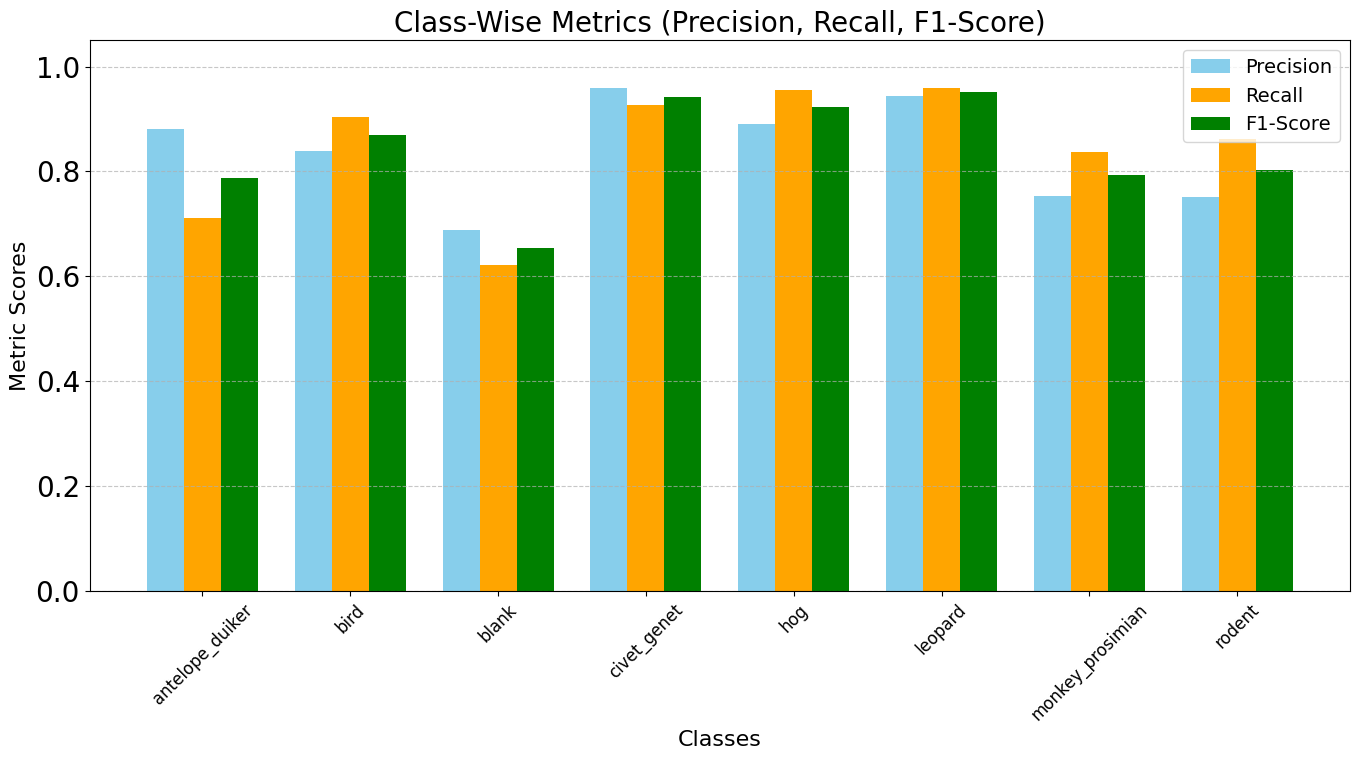

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Class names
classes = [
    "antelope_duiker", "bird", "blank", "civet_genet",
    "hog", "leopard", "monkey_prosimian", "rodent"
]

# Metrics for each class
precision = [0.880562, 0.838710, 0.688836, 0.959016, 0.890411, 0.944690, 0.752688, 0.751663]
recall = [0.712121, 0.904348, 0.622318, 0.926733, 0.955882, 0.959551, 0.836653, 0.862595]
f1_score = [0.787435, 0.870293, 0.653890, 0.942598, 0.921986, 0.952062, 0.792453, 0.803318]

# Bar width and x-axis positions
bar_width = 0.25
x = np.arange(len(classes))

# Plot bars for each metric
plt.figure(figsize=(14, 8))
plt.bar(x - bar_width, precision, width=bar_width, label="Precision", color="skyblue")
plt.bar(x, recall, width=bar_width, label="Recall", color="orange")
plt.bar(x + bar_width, f1_score, width=bar_width, label="F1-Score", color="green")

# Customizations
plt.title("Class-Wise Metrics (Precision, Recall, F1-Score)", fontsize=20)
plt.xlabel("Classes", fontsize=16)
plt.ylabel("Metric Scores", fontsize=16)
plt.xticks(x, classes, rotation=45, fontsize=12)
plt.legend(fontsize=14)
plt.ylim(0, 1.05)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Display the plot
plt.tight_layout()
plt.show()


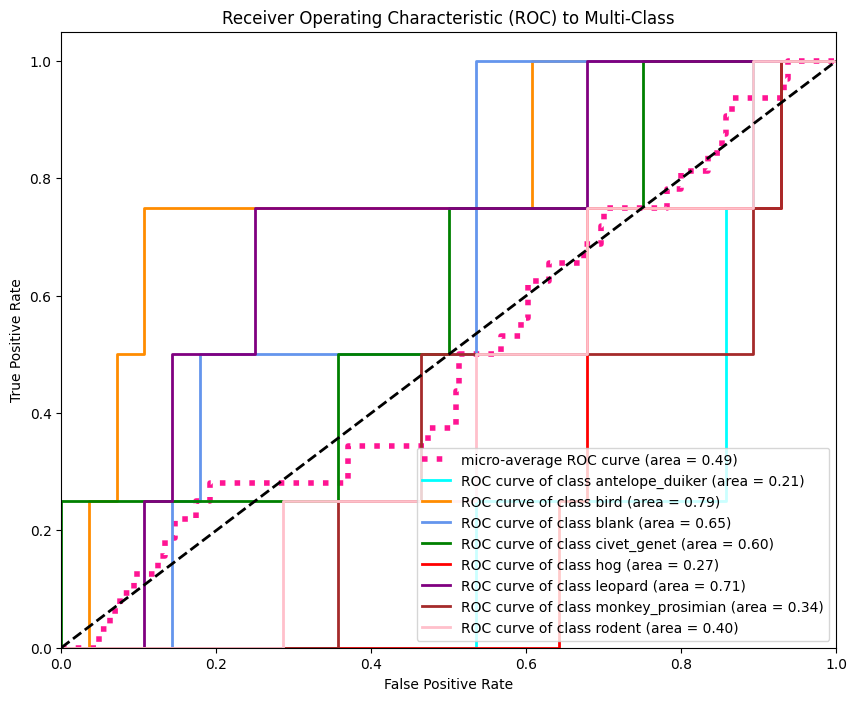

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelBinarizer

# Sample data (replace with your actual data)
true_labels = np.array(['antelope_duiker', 'bird', 'blank', 'civet_genet', 'hog', 'leopard', 'monkey_prosimian', 'rodent', 'bird', 'antelope_duiker', 'blank', 'civet_genet','hog', 'leopard', 'monkey_prosimian', 'rodent','antelope_duiker', 'bird', 'blank', 'civet_genet', 'hog', 'leopard', 'monkey_prosimian', 'rodent','antelope_duiker', 'bird', 'blank', 'civet_genet', 'hog', 'leopard', 'monkey_prosimian', 'rodent'])  # Example
predicted_probs = np.random.rand(len(true_labels), 8) # Example probabilities (8 classes)

# Convert string labels to numerical labels
label_binarizer = LabelBinarizer()
true_labels_bin = label_binarizer.fit_transform(true_labels)
n_classes = true_labels_bin.shape[1]

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(true_labels_bin[:, i], predicted_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(true_labels_bin.ravel(), predicted_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


# Plot ROC curves
plt.figure(figsize=(10, 8))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

colors = ['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'brown', 'pink']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(label_binarizer.classes_[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) to Multi-Class')
plt.legend(loc="lower right")
plt.show()

In [11]:
import pandas as pd
import numpy as np
import os
import time
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

# Start timer for overall process
start_time = time.time()

# Load your trained model
model_path = '/kaggle/input/final/other/default/1/myresnet1013.6_model.h5'
model = load_model(model_path)

# Print model summary to diagnose input shape
model.summary()

# Correct way to get input shape (handles different Keras versions)
try:
    input_shape = model.layers[0].input.shape[1:3]
except AttributeError:
    input_shape = model.input_shape[1:3]

img_height, img_width = input_shape

class_names = ['antelope_duiker', 'bird', 'blank', 'civet_genet', 'hog', 'leopard', 'monkey_prosimian', 'rodent']
test_dataset_path = '/kaggle/input/datadriven-conservision/test_features'
results = []
total_images = len(os.listdir(test_dataset_path))
processed_images = 0

# Start timer for prediction loop
prediction_start_time = time.time()

for filename in os.listdir(test_dataset_path):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
        img_path = os.path.join(test_dataset_path, filename)

        image_start_time = time.time()
        img = image.load_img(img_path, target_size=(img_height, img_width))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = img_array / 255.0
        image_end_time = time.time()
        image_processing_time = image_end_time - image_start_time

        predict_start_time = time.time()
        predictions = model.predict(img_array, verbose=0)
        predict_end_time = time.time()
        prediction_time = predict_end_time - predict_start_time

        probabilities = predictions[0]
        image_id = os.path.splitext(filename)[0]
        results.append([image_id] + list(probabilities))

        processed_images += 1
        print(f"Processed {processed_images}/{total_images}. Pred: {prediction_time:.4f}s, Img: {image_processing_time:.4f}s", end='\r') # Print on the same line

prediction_end_time = time.time()
prediction_loop_time = prediction_end_time - prediction_start_time

df = pd.DataFrame(results, columns=['id'] + class_names)
submission_csv_path = '/kaggle/working/submission.csv'
df.to_csv(submission_csv_path, index=False)

end_time = time.time()
total_time = end_time - start_time

print(f"\nSubmission CSV saved to {submission_csv_path}") # Newline before final output
print(f"Total processing time: {total_time:.2f} seconds")
print(f"Total Prediction loop time: {prediction_loop_time:.2f} seconds")

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 512, 512, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet101 (Functional)               │ (None, 16, 16, 2048)        │      42,658,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 8)                   │           1,032 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 43,872,522 (167.36 MB)

 Trainable params: 1,319,688 (5.03 MB)

 Non-trainable params: 42,552,832 (162.33 MB)

 Optimizer params: 2 (12.00 B)

Processed 4464/4464. Pred: 0.1051s, Img: 0.0095s
Submission CSV saved to /kaggle/working/submission.csv
Total processing time: 506.92 seconds
Total Prediction loop time: 503.18 seconds


In [12]:
import os
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
import datetime

# Hyperparameters
IMG_HEIGHT = 512  # Reduced resolution
IMG_WIDTH = 512
image_size = (IMG_HEIGHT, IMG_WIDTH)
batch_size = 8  # Reduced batch size
lrate = 0.001
epochs = 15

# Paths to datasets
train_data_dir = '/kaggle/input/datadriven-conservision/train_features'
validation_data_dir = '/kaggle/input/datadriven-conservision/val_features'

# Load the pre-trained model
model_path = '/kaggle/input/final/other/default/1/myresnet1013.6_model.h5'
try:
    model = load_model(model_path)
    print("Model loaded successfully!")
except Exception as e:
    print(f"Error loading model: {e}")
    raise

# Data augmentation configuration
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1.0 / 255)

# Create data generators
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=True
)

validation_generator = val_datagen.flow_from_directory(
    validation_data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=False
)

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lrate),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Add EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Add TensorBoard callback for visualization
log_dir = os.path.join("/kaggle/working/logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Train the model
print("Starting training...")
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=[early_stopping, tensorboard_callback],
    verbose=1
)

# Save the retrained model
retrained_model_path = '/kaggle/working/myresnet1013.7_model.h5'
model.save(retrained_model_path)
print(f"Retrained model saved to: {retrained_model_path}")


Model loaded successfully!
Found 13101 images belonging to 8 classes.
Found 3388 images belonging to 8 classes.
Starting training...
Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1638/1638 ━━━━━━━━━━━━━━━━━━━━ 0s 501ms/step - accuracy: 0.7653 - loss: 0.7059

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1638/1638 ━━━━━━━━━━━━━━━━━━━━ 1004s 561ms/step - accuracy: 0.7653 - loss: 0.7059 - val_accuracy: 0.8368 - val_loss: 0.5791
Epoch 2/15
1638/1638 ━━━━━━━━━━━━━━━━━━━━ 816s 496ms/step - accuracy: 0.7645 - loss: 0.7143 - val_accuracy: 0.8229 - val_loss: 0.5975
Epoch 3/15
1638/1638 ━━━━━━━━━━━━━━━━━━━━ 818s 497ms/step - accuracy: 0.7654 - loss: 0.6982 - val_accuracy: 0.8306 - val_loss: 0.5941
Epoch 4/15
1638/1638 ━━━━━━━━━━━━━━━━━━━━ 818s 497ms/step - accuracy: 0.7787 - loss: 0.6716 - val_accuracy: 0.8208 - val_loss: 0.6256
Epoch 5/15
1638/1638 ━━━━━━━━━━━━━━━━━━━━ 813s 494ms/step - accuracy: 0.7794 - loss: 0.6724 - val_accuracy: 0.8371 - val_loss: 0.5378
Epoch 6/15
1638/1638 ━━━━━━━━━━━━━━━━━━━━ 813s 494ms/step - accuracy: 0.7837 - loss: 0.6708 - val_accuracy: 0.8374 - val_loss: 0.5568
Epoch 7/15
1638/1638 ━━━━━━━━━━━━━━━━━━━━ 812s 494ms/step - accuracy: 0.7759 - loss: 0.6788 - val_accuracy: 0.8341 - val_loss: 0.5295
Epoch 8/15
1638/1638 ━━━━━━━━━━━━━━━━━━━━ 812s 494ms/step - accuracy: 0.

Model Summary:


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 512, 512, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet101 (Functional)               │ (None, 16, 16, 2048)        │      42,658,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 8)                   │           1,032 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 43,872,522 (167.36 MB)

 Trainable params: 1,319,688 (5.03 MB)

 Non-trainable params: 42,552,832 (162.33 MB)

 Optimizer params: 2 (12.00 B)

Found 3388 images belonging to 8 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


106/106 ━━━━━━━━━━━━━━━━━━━━ 94s 747ms/step


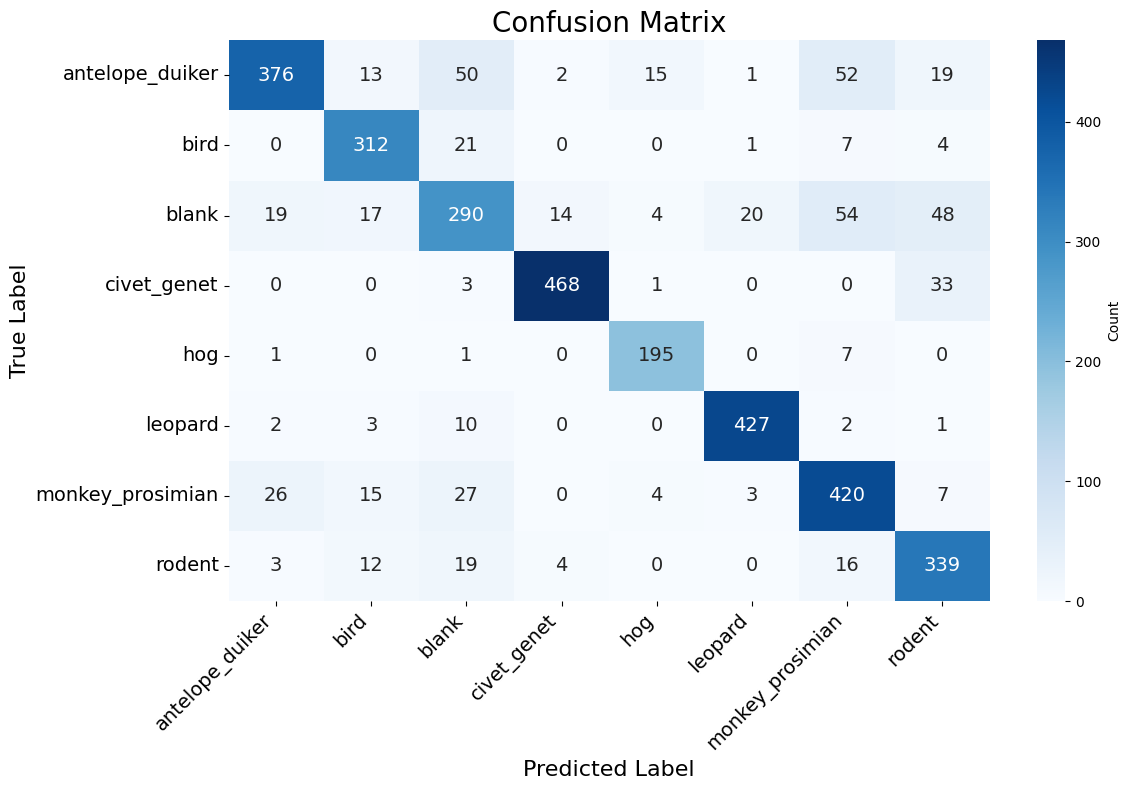

Classification Report:
                  precision    recall  f1-score      support
antelope_duiker    0.880562  0.712121  0.787435   528.000000
bird               0.838710  0.904348  0.870293   345.000000
blank              0.688836  0.622318  0.653890   466.000000
civet_genet        0.959016  0.926733  0.942598   505.000000
hog                0.890411  0.955882  0.921986   204.000000
leopard            0.944690  0.959551  0.952062   445.000000
monkey_prosimian   0.752688  0.836653  0.792453   502.000000
rodent             0.751663  0.862595  0.803318   393.000000
accuracy           0.834416  0.834416  0.834416     0.834416
macro avg          0.838322  0.847525  0.840504  3388.000000
weighted avg       0.836740  0.834416  0.832942  3388.000000

Class-Wise Metrics Table:
                             Class  Precision    Recall  F1-Score  Support
antelope_duiker    antelope_duiker   0.880562  0.712121  0.787435    528.0
bird                          bird   0.838710  0.904348  0.870293   

In [5]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

# Paths
model_path = "/kaggle/input/final/other/default/1/myresnet1013.6_model.h5"
val_dataset_path = "/kaggle/input/datadriven-conservision/val_features"

# Load the pre-trained model
model = load_model(model_path)

# Check model summary and expected input shape
print("Model Summary:")
model.summary()
expected_input_shape = model.input_shape[1:3]

# Data generator for the validation dataset
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0 / 255)

# Ensure validation generator uses the correct input shape
val_generator = datagen.flow_from_directory(
    val_dataset_path,
    target_size=expected_input_shape,
    batch_size=32,
    class_mode="categorical",
    shuffle=False
)

# Predict on the validation dataset
try:
    y_true = val_generator.classes
    y_pred_prob = model.predict(val_generator, verbose=1)
    y_pred = np.argmax(y_pred_prob, axis=1)
except ValueError as e:
    print("Error during prediction:", e)
    raise

# Get class names from the validation generator
class_names = list(val_generator.class_indices.keys())

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix with increased font sizes
plt.figure(figsize=(12, 8))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names,
    cbar_kws={"label": "Count"},
    annot_kws={"fontsize": 14}  # Font size of annotations
)
plt.title("Confusion Matrix", fontsize=20)  # Increased title font size
plt.xlabel("Predicted Label", fontsize=16)  # Increased label font size
plt.ylabel("True Label", fontsize=16)  # Increased label font size
plt.xticks(rotation=45, ha="right", fontsize=14)  # Increased tick font size
plt.yticks(rotation=0, fontsize=14)  # Increased tick font size
plt.tight_layout()
plt.show()

# Classification report
report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)

# Convert the classification report to a DataFrame for better readability
report_df = pd.DataFrame(report).transpose()

# Print the classification report
print("Classification Report:")
print(report_df)

# Save the classification metrics to a CSV file
report_df.to_csv("classification_metrics_val.csv", index=True)

# Extract class-wise metrics
accuracy = accuracy_score(y_true, y_pred)
class_wise_metrics = report_df.loc[class_names, ["precision", "recall", "f1-score"]]
class_wise_metrics["support"] = report_df.loc[class_names, "support"]

# Create class-wise metrics table
accuracy_table = pd.DataFrame({
    "Class": class_names,
    "Precision": class_wise_metrics["precision"],
    "Recall": class_wise_metrics["recall"],
    "F1-Score": class_wise_metrics["f1-score"],
    "Support": class_wise_metrics["support"]
})

print("\nClass-Wise Metrics Table:")
print(accuracy_table)

# Save the accuracy table as a CSV file
accuracy_table.to_csv("class_wise_metrics_val.csv", index=False)

# Print overall accuracy
print(f"\nOverall Accuracy: {accuracy * 100:.2f}%")


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


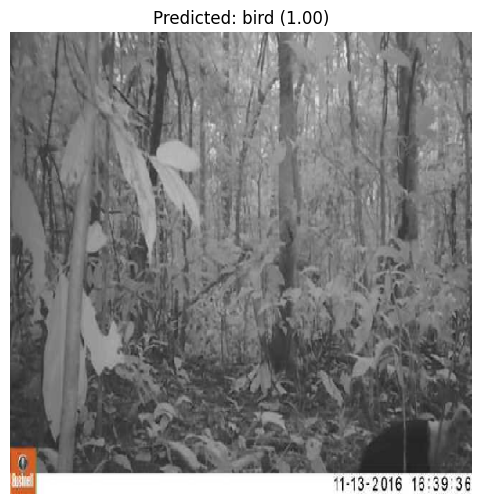

In [6]:
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model('/kaggle/input/resnet101-3.6/other/default/1/myresnet1013.6_model.h5')  # Adjust the path to your saved model

# Define class labels (adjust based on your dataset)
class_labels = ['antelope_duiker', 'bird', 'blank', 'civet_genet', 'hog', 'leopard', 'monkey_prosimian', 'rodent']

# Function to preprocess and predict an image
def predict_and_display(image_path, model, target_size=(512, 512), class_labels=None):
    # Load and preprocess the image (resize to the correct input size for the model)
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img) / 255.0  # Normalize the image
    img_batch = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Make a prediction
    predictions = model.predict(img_batch)
    predicted_class_index = np.argmax(predictions[0])
    predicted_class = class_labels[predicted_class_index] if class_labels else predicted_class_index
    confidence_score = predictions[0][predicted_class_index]

    # Display the image with prediction
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {predicted_class} ({confidence_score:.2f})")
    plt.show()

# Provide the path to your input image
image_path = '/kaggle/input/datadriven-conservision/test_features/ZJ016493.jpg'  # Replace with your image path

# Predict and display the result
predict_and_display(image_path, model, target_size=(512, 512), class_labels=class_labels)

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


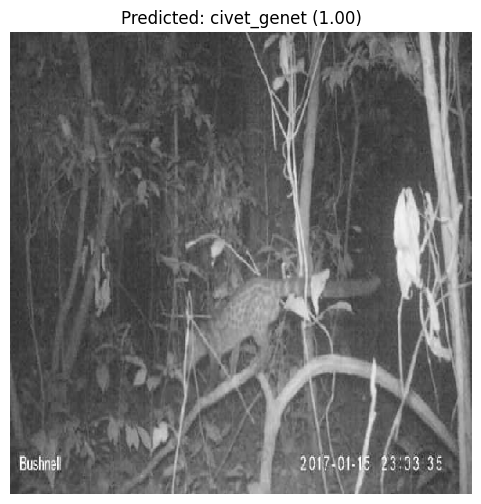

In [4]:
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model('/kaggle/input/resnet101-3.6/other/default/1/myresnet1013.6_model.h5')  # Adjust the path to your saved model

# Define class labels (adjust based on your dataset)
class_labels = ['antelope_duiker', 'bird', 'blank', 'civet_genet', 'hog', 'leopard', 'monkey_prosimian', 'rodent']

# Function to preprocess and predict an image
def predict_and_display(image_path, model, target_size=(512, 512), class_labels=None):
    # Load and preprocess the image (resize to the correct input size for the model)
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img) / 255.0  # Normalize the image
    img_batch = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Make a prediction
    predictions = model.predict(img_batch)
    predicted_class_index = np.argmax(predictions[0])
    predicted_class = class_labels[predicted_class_index] if class_labels else predicted_class_index
    confidence_score = predictions[0][predicted_class_index]

    # Display the image with prediction
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {predicted_class} ({confidence_score:.2f})")
    plt.show()

# Provide the path to your input image
image_path = '/kaggle/input/datadriven-conservision/val_features/civet_genet/ZJ013247.jpg'  # Replace with your image path

# Predict and display the result
predict_and_display(image_path, model, target_size=(512, 512), class_labels=class_labels)

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


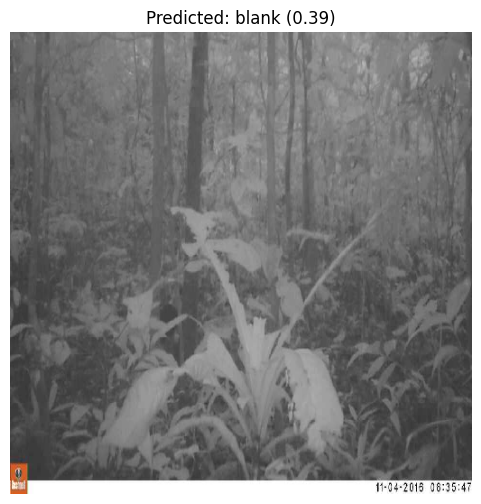

In [7]:
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model('/kaggle/input/resnet101-3.6/other/default/1/myresnet1013.6_model.h5')  # Adjust the path to your saved model

# Define class labels (adjust based on your dataset)
class_labels = ['antelope_duiker', 'bird', 'blank', 'civet_genet', 'hog', 'leopard', 'monkey_prosimian', 'rodent']

# Function to preprocess and predict an image
def predict_and_display(image_path, model, target_size=(512, 512), class_labels=None):
    # Load and preprocess the image (resize to the correct input size for the model)
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img) / 255.0  # Normalize the image
    img_batch = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Make a prediction
    predictions = model.predict(img_batch)
    predicted_class_index = np.argmax(predictions[0])
    predicted_class = class_labels[predicted_class_index] if class_labels else predicted_class_index
    confidence_score = predictions[0][predicted_class_index]

    # Display the image with prediction
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {predicted_class} ({confidence_score:.2f})")
    plt.show()
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model('/kaggle/input/resnet101-3.6/other/default/1/myresnet1013.6_model.h5')  # Adjust the path to your saved model

# Define class labels (adjust based on your dataset)
class_labels = ['antelope_duiker', 'bird', 'blank', 'civet_genet', 'hog', 'leopard', 'monkey_prosimian', 'rodent']

# Function to preprocess and predict an image
def predict_and_display(image_path, model, target_size=(512, 512), class_labels=None):
    # Load and preprocess the image (resize to the correct input size for the model)
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img) / 255.0  # Normalize the image
    img_batch = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Make a prediction
    predictions = model.predict(img_batch)
    predicted_class_index = np.argmax(predictions[0])
    predicted_class = class_labels[predicted_class_index] if class_labels else predicted_class_index
    confidence_score = predictions[0][predicted_class_index]

    # Display the image with prediction
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {predicted_class} ({confidence_score:.2f})")
    plt.show()

# Provide the path to your input image
image_path = '/kaggle/input/datadriven-conservision/test_features/ZJ016504.jpg'  # Replace with your image path

# Predict and display the result
predict_and_display(image_path, model, target_size=(512, 512), class_labels=class_labels)
# Provide the path to your input image
image_path = '/kaggle/input/datadriven-conservision/test_features/ZJ016504.jpg'  # Replace with your image path

# Predict and display the result
predict_and_display(image_path, model, target_size=(512, 512), class_labels=class_labels)

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


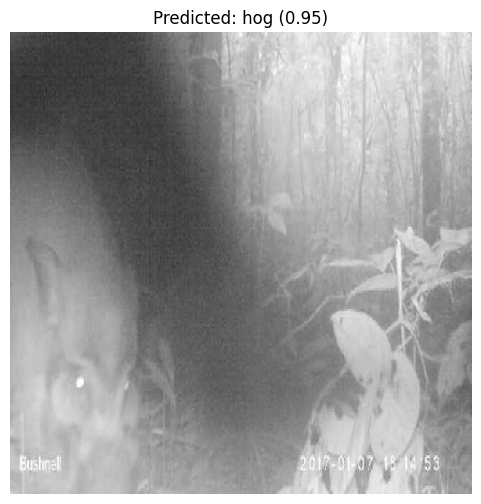

In [8]:
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model('/kaggle/input/resnet101-3.6/other/default/1/myresnet1013.6_model.h5')  # Adjust the path to your saved model

# Define class labels (adjust based on your dataset)
class_labels = ['antelope_duiker', 'bird', 'blank', 'civet_genet', 'hog', 'leopard', 'monkey_prosimian', 'rodent']

# Function to preprocess and predict an image
def predict_and_display(image_path, model, target_size=(512, 512), class_labels=None):
    # Load and preprocess the image (resize to the correct input size for the model)
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img) / 255.0  # Normalize the image
    img_batch = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Make a prediction
    predictions = model.predict(img_batch)
    predicted_class_index = np.argmax(predictions[0])
    predicted_class = class_labels[predicted_class_index] if class_labels else predicted_class_index
    confidence_score = predictions[0][predicted_class_index]

    # Display the image with prediction
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {predicted_class} ({confidence_score:.2f})")
    plt.show()

# Provide the path to your input image
image_path = '/kaggle/input/datadriven-conservision/test_features/ZJ016525.jpg'  # Replace with your image path

# Predict and display the result
predict_and_display(image_path, model, target_size=(512, 512), class_labels=class_labels)

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


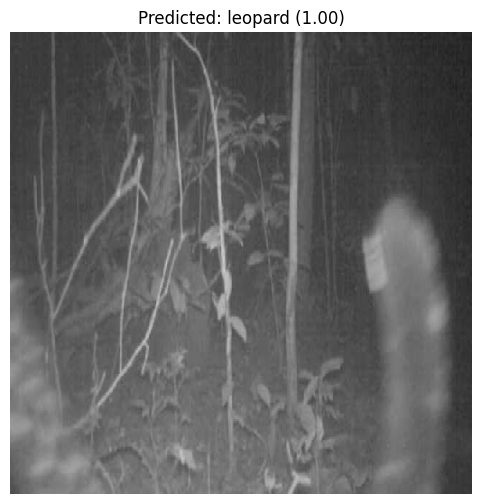

In [9]:
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model('/kaggle/input/resnet101-3.6/other/default/1/myresnet1013.6_model.h5')  # Adjust the path to your saved model

# Define class labels (adjust based on your dataset)
class_labels = ['antelope_duiker', 'bird', 'blank', 'civet_genet', 'hog', 'leopard', 'monkey_prosimian', 'rodent']

# Function to preprocess and predict an image
def predict_and_display(image_path, model, target_size=(512, 512), class_labels=None):
    # Load and preprocess the image (resize to the correct input size for the model)
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img) / 255.0  # Normalize the image
    img_batch = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Make a prediction
    predictions = model.predict(img_batch)
    predicted_class_index = np.argmax(predictions[0])
    predicted_class = class_labels[predicted_class_index] if class_labels else predicted_class_index
    confidence_score = predictions[0][predicted_class_index]

    # Display the image with prediction
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {predicted_class} ({confidence_score:.2f})")
    plt.show()

# Provide the path to your input image
image_path = '/kaggle/input/datadriven-conservision/test_features/ZJ016546.jpg'  # Replace with your image path

# Predict and display the result
predict_and_display(image_path, model, target_size=(512, 512), class_labels=class_labels)

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


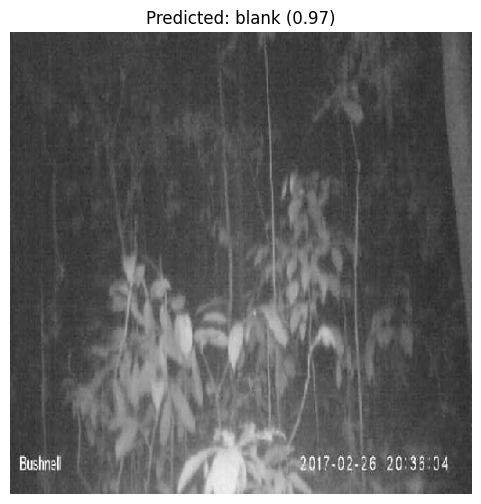

In [10]:
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model('/kaggle/input/resnet101-3.6/other/default/1/myresnet1013.6_model.h5')  # Adjust the path to your saved model

# Define class labels (adjust based on your dataset)
class_labels = ['antelope_duiker', 'bird', 'blank', 'civet_genet', 'hog', 'leopard', 'monkey_prosimian', 'rodent']

# Function to preprocess and predict an image
def predict_and_display(image_path, model, target_size=(512, 512), class_labels=None):
    # Load and preprocess the image (resize to the correct input size for the model)
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img) / 255.0  # Normalize the image
    img_batch = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Make a prediction
    predictions = model.predict(img_batch)
    predicted_class_index = np.argmax(predictions[0])
    predicted_class = class_labels[predicted_class_index] if class_labels else predicted_class_index
    confidence_score = predictions[0][predicted_class_index]

    # Display the image with prediction
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {predicted_class} ({confidence_score:.2f})")
    plt.show()

# Provide the path to your input image
image_path = '/kaggle/input/datadriven-conservision/test_features/ZJ016575.jpg'  # Replace with your image path

# Predict and display the result
predict_and_display(image_path, model, target_size=(512, 512), class_labels=class_labels)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


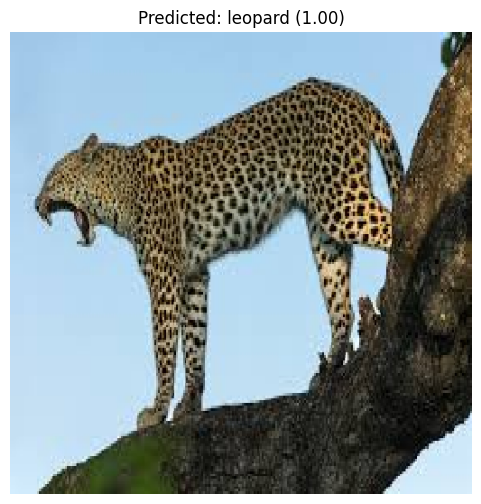

In [11]:
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model('/kaggle/input/resnet101-3.6/other/default/1/myresnet1013.6_model.h5')  # Adjust the path to your saved model

# Define class labels (adjust based on your dataset)
class_labels = ['antelope_duiker', 'bird', 'blank', 'civet_genet', 'hog', 'leopard', 'monkey_prosimian', 'rodent']

# Function to preprocess and predict an image
def predict_and_display(image_path, model, target_size=(512, 512), class_labels=None):
    # Load and preprocess the image (resize to the correct input size for the model)
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img) / 255.0  # Normalize the image
    img_batch = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Make a prediction
    predictions = model.predict(img_batch)
    predicted_class_index = np.argmax(predictions[0])
    predicted_class = class_labels[predicted_class_index] if class_labels else predicted_class_index
    confidence_score = predictions[0][predicted_class_index]

    # Display the image with prediction
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {predicted_class} ({confidence_score:.2f})")
    plt.show()

# Provide the path to your input image
image_path = '/kaggle/input/lepord/download.jpg'  # Replace with your image path

# Predict and display the result
predict_and_display(image_path, model, target_size=(512, 512), class_labels=class_labels)

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


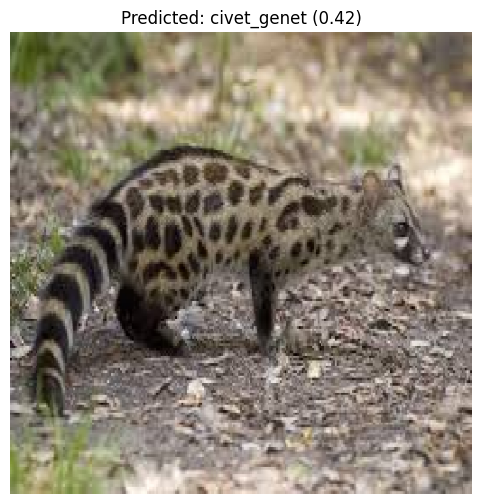

In [18]:
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model('/kaggle/input/resnet101-3.6/other/default/1/myresnet1013.6_model.h5')  # Adjust the path to your saved model

# Define class labels (adjust based on your dataset)
class_labels = ['antelope_duiker', 'bird', 'blank', 'civet_genet', 'hog', 'leopard', 'monkey_prosimian', 'rodent']

# Function to preprocess and predict an image
def predict_and_display(image_path, model, target_size=(512, 512), class_labels=None):
    # Load and preprocess the image (resize to the correct input size for the model)
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img) / 255.0  # Normalize the image
    img_batch = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Make a prediction
    predictions = model.predict(img_batch)
    predicted_class_index = np.argmax(predictions[0])
    predicted_class = class_labels[predicted_class_index] if class_labels else predicted_class_index
    confidence_score = predictions[0][predicted_class_index]

    # Display the image with prediction
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {predicted_class} ({confidence_score:.2f})")
    plt.show()

# Provide the path to your input image
image_path = '/kaggle/input/unseen/download (3).jpg'  # Replace with your image path

# Predict and display the result
predict_and_display(image_path, model, target_size=(512, 512), class_labels=class_labels)

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


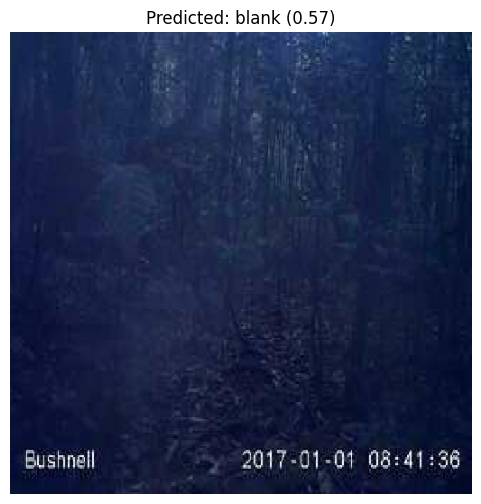

In [24]:
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model('/kaggle/input/resnet101-3.6/other/default/1/myresnet1013.6_model.h5')  # Adjust the path to your saved model

# Define class labels (adjust based on your dataset)
class_labels = ['antelope_duiker', 'bird', 'blank', 'civet_genet', 'hog', 'leopard', 'monkey_prosimian', 'rodent']

# Function to preprocess and predict an image
def predict_and_display(image_path, model, target_size=(512, 512), class_labels=None):
    # Load and preprocess the image (resize to the correct input size for the model)
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img) / 255.0  # Normalize the image
    img_batch = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Make a prediction
    predictions = model.predict(img_batch)
    predicted_class_index = np.argmax(predictions[0])
    predicted_class = class_labels[predicted_class_index] if class_labels else predicted_class_index
    confidence_score = predictions[0][predicted_class_index]

    # Display the image with prediction
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {predicted_class} ({confidence_score:.2f})")
    plt.show()

# Provide the path to your input image
image_path = '/kaggle/input/datadriven-conservision/test_features/ZJ016732.jpg'  # Replace with your image path

# Predict and display the result
predict_and_display(image_path, model, target_size=(512, 512), class_labels=class_labels)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


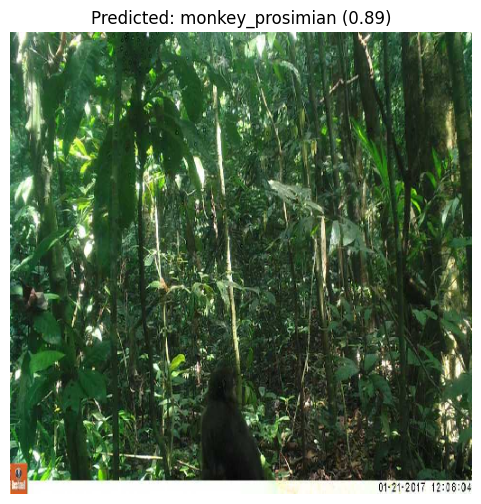

In [27]:
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model('/kaggle/input/resnet101-3.6/other/default/1/myresnet1013.6_model.h5')  # Adjust the path to your saved model

# Define class labels (adjust based on your dataset)
class_labels = ['antelope_duiker', 'bird', 'blank', 'civet_genet', 'hog', 'leopard', 'monkey_prosimian', 'rodent']

# Function to preprocess and predict an image
def predict_and_display(image_path, model, target_size=(512, 512), class_labels=None):
    # Load and preprocess the image (resize to the correct input size for the model)
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img) / 255.0  # Normalize the image
    img_batch = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Make a prediction
    predictions = model.predict(img_batch)
    predicted_class_index = np.argmax(predictions[0])
    predicted_class = class_labels[predicted_class_index] if class_labels else predicted_class_index
    confidence_score = predictions[0][predicted_class_index]

    # Display the image with prediction
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {predicted_class} ({confidence_score:.2f})")
    plt.show()

# Provide the path to your input image
image_path = '/kaggle/input/datadriven-conservision/test_features/ZJ016823.jpg'  # Replace with your image path

# Predict and display the result
predict_and_display(image_path, model, target_size=(512, 512), class_labels=class_labels)